In [1]:
import sys
import os
sys.path.insert(0, os.path.normpath(os.getcwd() + os.sep + os.pardir))

In [83]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from nltk import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, roc_auc_score, confusion_matrix
from model_training import WordCountTransformer

In [3]:
stop_words = set(stopwords.words('English'))

In [114]:
answerable_data = utils.load_data('../data/aqfiltered.json', 'answerable')

In [5]:
def answerable_preprocessor(sentence):
    sentence = utils.check_quotations(sentence)
    sentence = word_tokenize(sentence)
    
    for i in range(len(sentence)):
        sentence[i] = utils.check_camel_snakecase(sentence[i])
        sentence[i] = sentence[i].lower()
        
        if sentence[i] in stop_words and sentence[i] not in ['who', 'what', 'when', 'where', 'why', 'how']:
            sentence[i] = ""
        elif sentence[i].isnumeric():
            sentence[i] = "numericnumber"
        elif utils.is_spelled_out_number(sentence[i]):
            sentence[i] = "nonnumericnumber"
        elif utils.is_TA_or_instructor_name(sentence[i]):
            sentence[i] = "name"
        elif utils.is_error_code(sentence[i]):
            sentence[i] = "errorcode"
        elif utils.is_system_word(sentence[i]):
            sentence[i] = "sys"
        elif utils.is_function(sentence[i]):
            sentence[i] = "func"

    return ' '.join(sentence)

In [115]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('ngram', TfidfVectorizer(preprocessor=None)),
    ])),
    ('clf', MultinomialNB())
])

In [118]:
print('Accuracy: {}'.format(np.mean(cross_val_score(pipeline, data[:,0], data[:,1], n_jobs=-1))))

Accuracy: 0.7986742424242423


In [117]:
data = np.array([[answerable_data[:,0][i], answerable_data[:,1][i]] for i in range(len(answerable_data)) if answerable_data[:,1][i] == 't' or answerable_data[:,1][i] == 'f'])

In [91]:
pipeline.fit(data[:,0], data[:,1])

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('ngram',
                                                 TfidfVectorizer(analyzer='word',
                                                                 binary=False,
                                                                 decode_error='strict',
                                                                 dtype=<class 'numpy.float64'>,
                                                                 encoding='utf-8',
                                                                 input='content',
                                                                 lowercase=True,
                                                                 max_df=1.0,
                                                                 max_features=None,
                                                                 min_df=1,
                     

In [119]:
param_grid = {
    'features__ngram__ngram_range': [(1,1), (1,2), (1,3)],
    'features__ngram__max_features': [None, 100, 250, 500, 1000, 1500, 2000, 2500, 3000],
    'features__ngram__use_idf': (True, False),
    'features__ngram__norm': ('l1', 'l2'),
#     'clf__n_estimators': [100, 250, 500, 750, 1000],
#     'clf__max_features': ['auto', 'log2'],
#     'clf__max_depth': [None, 100, 500, 1000],
#     'clf__min_samples_split': [2, 5, 10, 12],
#     'clf__min_samples_leaf': [1, 2, 4, 8],
#     'clf__criterion': ['gini', 'entropy'],
#     'clf__bootstrap': [True, False],
#     'clf__C': [.01, .1, 1, 10, 100],
#     'clf__class_weight': [None, 'balanced']
    'clf__alpha': [1, .1, .01, .001]
}

search = GridSearchCV(pipeline, param_grid, n_jobs=-1)
search.fit(data[:,0], data[:,1])

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('ngram',
                                                                        TfidfVectorizer(analyzer='word',
                                                                                        binary=False,
                                                                                        decode_error='strict',
                                                                                        dtype=<class 'numpy.float64'>,
                                                                                        encoding='utf-8',
                                                                                        input='content',
                                                                     

In [120]:
t_precision = np.mean(cross_val_score(search.best_estimator_, data[:,0], data[:,1], cv=5, scoring=make_scorer(precision_score, pos_label='t'), n_jobs=-1))
t_recall = np.mean(cross_val_score(search.best_estimator_, data[:,0], data[:,1], cv=5, scoring=make_scorer(recall_score, pos_label='t'), n_jobs=-1))
t_f1 = np.mean(cross_val_score(search.best_estimator_, data[:,0], data[:,1], cv=5, scoring=make_scorer(f1_score, pos_label='t'), n_jobs=-1))
                
f_precision = np.mean(cross_val_score(search.best_estimator_, data[:,0], data[:,1], cv=5, scoring=make_scorer(precision_score, pos_label='f'), n_jobs=-1))
f_recall = np.mean(cross_val_score(search.best_estimator_, data[:,0], data[:,1], cv=5, scoring=make_scorer(recall_score, pos_label='f'), n_jobs=-1))
f_f1 = np.mean(cross_val_score(search.best_estimator_, data[:,0], data[:,1], cv=5, scoring=make_scorer(f1_score, pos_label='f'), n_jobs=-1))

t = [t_precision, t_recall, t_f1]
f = [f_precision, f_recall, f_f1]
pd.DataFrame((t, f), index=['t', 'f'], columns=['Precision', 'Recall', 'F1 Score'])

,Precision,Recall,F1 Score
t,0.807549,0.857353,0.830089
f,0.848333,0.790441,0.816075


In [121]:
print('Accuracy: {}'.format(np.mean(cross_val_score(search.best_estimator_, data[:,0], data[:,1], n_jobs=-1))))
print('Area Under Curve ROC: {}'.format(np.mean(cross_val_score(search.best_estimator_, data[:,0], data[:,1], cv=5, scoring='roc_auc', n_jobs=-1))))

Accuracy: 0.8234848484848485
Area Under Curve ROC: 0.8824908088235294


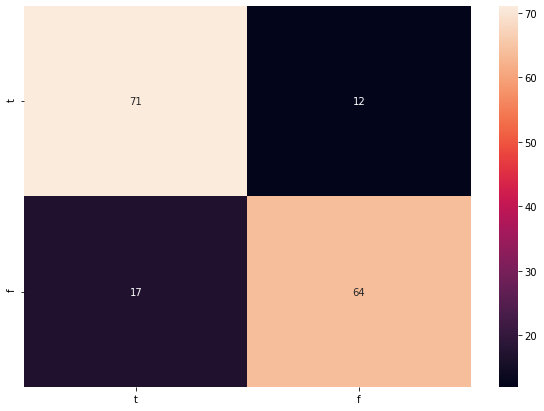

In [122]:
y_pred = cross_val_predict(search.best_estimator_, data[:,0], data[:,1], cv=5)
conf_mat = confusion_matrix(data[:,1], y_pred, labels=['t', 'f'])
df_cm = pd.DataFrame(conf_mat, index = [i for i in ['t', 'f']],
                  columns = [i for i in ['t', 'f']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [105]:
for i in range(len(y_pred)):
    if y_pred[i] != data[:,1][i]:
        print(data[:,0][i])
        print(y_pred[i])
        print()

next().length() isn't working as expected
t

I'm having trouble installing packages necessary for SDL
f

constructor of Arraydeque and linkedDeque
t

How do I do things





regarding stack
t

I would like to hack countable thoughts. 
t

cant find SDL2/SDL2_gfxPrimitives.h "Clang not found"
f

I am getting an UnsupportedOperationException error. 
t

I created some tests in my Main for addFront/addBack and they work as expected when I add a small number of elements, but they are not passing the LinkedDeque tests.

My removeBack is not working and not sure why, currently debugging. 
f

Something is weird with timeouts and we're not sure why
t

I don't know how to initialize arrays in java.
f

More error messages from mystring.c
t

add front is being weird and im not sure why.
t

Remove doesn't work and we can't figure out why.
t

intellij hangs indefinitely when running tests instead of failing normally
f

how to make a linked deque
t

Having trouble with assigning values to rdi
f

shoul

In [75]:
for i in range(len(data[:,1])):
    if search.best_estimator_.predict(data[:,0])[i] != data[:,1][i]:
        print(data[:,0][i])
        print(search.best_estimator_.predict([data[:,0][i]]))
        print()

Remove doesn't work and we can't figure out why.
['t']

shouldn't be returning null

['t']

I keep timing out. Especially when I pass it to Git. I don't know how to make my code more efficient
['t']

Don't think my array storing my values is getting properly initialized, all values always null

['f']

I created some tests in my Main for addFront/addBack and they work as expected when I add a small number of elements, but they are not passing the LinkedDeque tests.

My removeBack is not working and not sure why, currently debugging. 
['f']

How do I do things





regarding stack
['t']

I don't exactly know how to set up the constructor for the guitar string
['t']

Need help explaining plateaus in iter for linked list
['f']

I need a lot of help.  Also I waited for an hour to get down to nobody left in the queue just to see it at 0 people for 15 minutes.  Nobody contacted me, the page refreshed, and now there are 5 people in front of me.  I really need help on this and 

['t']

how to m

In [22]:
search.best_estimator_.predict(["I keep timing out. Especially when I pass it to Git. I don't know how to make my code more efficient"])

array(['f'], dtype='<U332')

In [171]:
search.best_estimator_

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('ngram',
                                                 TfidfVectorizer(analyzer='word',
                                                                 binary=False,
                                                                 decode_error='strict',
                                                                 dtype=<class 'numpy.float64'>,
                                                                 encoding='utf-8',
                                                                 input='content',
                                                                 lowercase=True,
                                                                 max_df=1.0,
                                                                 max_features=500,
                                                                 min_df=1,
                      